In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import pandas as pd
from skimage import io, img_as_float, img_as_float32



In [17]:
# Dataset Class to load images from CSV
class ImageDataset(Dataset):
    def __init__(self, csv_file, channel = 0, transform=None):
        self.data = pd.read_csv(csv_file)  # CSV with 'input' and 'target' columns
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 1]  # Input column (image paths)
        image = img_as_float32(io.imread(img_name, as_gray=True))  # Open the image
        
        # Select only the first channel (e.g., red channel)
        #image = image#[:, :, 0]

        target_name = self.data.iloc[idx, 2]  # Target column (label)
        target = img_as_float32(io.imread(target_name))
        
        # Select only the first channel (e.g., red channel)
        targets = {}
        targets[0] = target[:, :, 0]
        targets[1] = target[:, :, 1]
        targets[2] = target[:, :, 2]
        if self.transform:
            image = self.transform(image)
            targets[0] = self.transform(targets[0])
            targets[1] = self.transform(targets[1])
            targets[2] = self.transform(targets[2])
        
        return image, targets

# Define the network (1-layer CNN)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=7, stride=1, padding=3, bias=False)
        #self.conv2 = nn.Conv2d(in_channels=5, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        #x = self.conv2(x)
        x = torch.relu(x)
        return x

# Data Preprocessing and Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    # Convert images to PyTorch tensors
])


In [18]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder: Downsampling path
        self.enc_conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        # Decoder: Upsampling path
        self.up_conv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.up_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.up_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)

        # Final output layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1, stride=1)

    def forward(self, x):
        # Encoder
        enc1 = torch.relu(self.enc_conv1(x))
        enc2 = torch.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = torch.relu(self.enc_conv3(self.pool(enc2)))

        # Bottleneck
        bottleneck = torch.relu(self.bottleneck(self.pool(enc3)))

        # Decoder
        up3 = torch.relu(self.up_conv3(bottleneck))
        dec3 = torch.relu(self.dec_conv3(torch.cat((up3, enc3), dim=1)))
        
        up2 = torch.relu(self.up_conv2(dec3))
        dec2 = torch.relu(self.dec_conv2(torch.cat((up2, enc2), dim=1)))

        up1 = torch.relu(self.up_conv1(dec2))
        dec1 = torch.relu(self.dec_conv1(torch.cat((up1, enc1), dim=1)))

        # Final output layer
        output = self.final_conv(dec1)
        return output


In [20]:
class SmallUNet(nn.Module):
    def __init__(self):
        super(SmallUNet, self).__init__()

        # Encoder: Downsampling path
        self.enc_conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Decoder: Upsampling path
        self.up_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.up_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)

        # Final output layer
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1, stride=1)

    def forward(self, x):
        # Encoder
        enc1 = torch.relu(self.enc_conv1(x))
        enc2 = torch.relu(self.enc_conv2(self.pool(enc1)))

        # Bottleneck
        bottleneck = torch.relu(self.bottleneck(self.pool(enc2)))

        # Decoder
        up2 = torch.relu(self.up_conv2(bottleneck))
        dec2 = torch.relu(self.dec_conv2(torch.cat((up2, enc2), dim=1)))
        
        up1 = torch.relu(self.up_conv1(dec2))
        dec1 = torch.relu(self.dec_conv1(torch.cat((up1, enc1), dim=1)))

        # Final output layer
        output = self.final_conv(dec1)
        return output

In [21]:
class TinyUNet(nn.Module):
    def __init__(self):
        super(TinyUNet, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Decoder
        self.up_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.up_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        enc1 = torch.relu(self.enc_conv1(x))
        enc2 = torch.relu(self.enc_conv2(self.pool(enc1)))

        # Bottleneck
        bottleneck = torch.relu(self.bottleneck(self.pool(enc2)))

        # Decoder
        up2 = torch.relu(self.up_conv2(bottleneck))
        dec2 = torch.cat((up2, enc2), dim=1)
        
        up1 = torch.relu(self.up_conv1(torch.relu(self.dec_conv2(dec2))))
        output = torch.relu(self.final_conv(torch.cat((up1, enc1), dim=1)))

        return output

In [10]:
class TinierUNet(nn.Module):
    def __init__(self):
        super(TinierUNet, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Decoder
        self.up_conv = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        enc1 = torch.relu(self.enc_conv1(x))
        
        # Bottleneck
        bottleneck = torch.relu(self.bottleneck(self.pool(enc1)))

        # Decoder
        up = torch.relu(self.up_conv(bottleneck))
        output = torch.relu(self.final_conv(torch.cat((up, enc1), dim=1)))

        return output

In [22]:
# Load the dataset
csv_file = 'file_locations.csv'  # Your CSV file with image paths and targets
dataset = ImageDataset(csv_file=csv_file, transform=transform)

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(dataset.data, test_size=0.2, random_state=42)

# Create DataLoader objects for both train and validation datasets
train_dataset = torch.utils.data.Subset(dataset, train_data.index)
val_dataset = torch.utils.data.Subset(dataset, val_data.index)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [23]:
for _, (X, y) in zip(range(1), train_loader):
    print(X.shape)
    print(y[1].shape)
    print(X.dtype, X.float().dtype)
    
    

torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.float32 torch.float32


In [24]:
from tqdm import tqdm

In [14]:
# Define the model, loss function, and optimizer
models = [TinierUNet() for i in range(3)]
criterion = nn.L1Loss()

# Training Loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        for channel in range(3):
            model = models[channel]
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            images, labels = images.to(device), labels[channel].to(device)
    
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            running_loss += loss.item()
            total += labels.size(0)
        
    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

# Testing Loop
def test(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            
            running_loss += loss.item()
        
    
    epoch_loss = running_loss / len(val_loader)
    return epoch_loss

# Main training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = test(model, val_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")


NameError: name 'model' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Function to convert a tensor to a numpy image
# Function to convert a tensor to a numpy image
def tensor_to_image(tensor):
    # Convert from (C, H, W) to (H, W, C)
    tensor = tensor.cpu().detach()
    image = tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    
    # If values are in range [0, 255], normalize to [0, 1]
    if image.max() > 1:
        print("Hi")
        image = image / 1.0
    
    return image

# Modify the test function to plot images
def test_and_plot(model, val_loader, device):
    model.eval()
    with torch.no_grad():
        for _, (images, targets) in zip(range(5), val_loader):
            images, targets = images.to(device), targets.to(device)

            # Forward pass through the network
            outputs = model(images)

            # Convert the first batch of images, targets, and outputs to numpy
            input_image = tensor_to_image(images[26])  # First image in the batch
            target_image = tensor_to_image(targets[26])  # Target (assuming it's a label, adjust if it's an image)
            filtered_image = tensor_to_image(outputs[26])  # Filtered output image (after CNN)
            print(filtered_image.shape)

            # Plot the images side by side
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            
            axes[0].imshow(input_image)
            axes[0].set_title('Input Image')
            axes[0].axis('off')
            
            axes[1].imshow(target_image)  # Assuming target is a single-channel label/image
            axes[1].set_title('Target')
            axes[1].axis('off')
            
            axes[2].imshow(filtered_image)
            axes[2].set_title('Filtered Image (CNN Output)')
            axes[2].axis('off')
            
            plt.show()
            break  # Only plot one batch

# Main script to test and plot the images
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Use the function to plot images from the validation set
test_and_plot(model, val_loader, device)

In [27]:
# Define the model, loss function, and optimizer
models = [SmallUNet() for i in range(3)]
criterion = nn.L1Loss()
optimizers = [optim.Adam(models[i].parameters(), lr=0.001) for i in range(3)]

# Training Loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        for channel in range(3):
            model = models[channel]
        
            images, label_channel = images.to(device), labels[channel].to(device)
    
            optimizers[channel].zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, label_channel)  # Compute loss
            loss.backward()  # Backward pass
            optimizers[channel].step()  # Update weights
            
            running_loss += loss.item()
            total += label_channel.size(0)
        
    epoch_loss = running_loss / len(train_loader) / 3
    return epoch_loss

# Testing Loop
def test(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            for channel in range(3):
                images, labels_channel = images.to(device), labels[channel].to(device)
                model = models[channel]
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels_channel)  # Compute loss
                
                running_loss += loss.item()
            
    
    epoch_loss = running_loss / len(val_loader) / 3
    return epoch_loss

# Main training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for model in models:
    model.to(device)

num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizers, device)
    val_loss = test(model, val_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")


100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Epoch [1/50]
Train Loss: 0.2385
Val Loss: 0.1228


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [2/50]
Train Loss: 0.0835
Val Loss: 0.0730


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Epoch [3/50]
Train Loss: 0.0682
Val Loss: 0.0667


100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Epoch [4/50]
Train Loss: 0.0634
Val Loss: 0.0625


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [5/50]
Train Loss: 0.0599
Val Loss: 0.0593


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Epoch [6/50]
Train Loss: 0.0563
Val Loss: 0.0551


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Epoch [7/50]
Train Loss: 0.0536
Val Loss: 0.0539


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Epoch [8/50]
Train Loss: 0.0524
Val Loss: 0.0520


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Epoch [9/50]
Train Loss: 0.0494
Val Loss: 0.0506


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Epoch [10/50]
Train Loss: 0.0487
Val Loss: 0.0489


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Epoch [11/50]
Train Loss: 0.0471
Val Loss: 0.0494


100%|██████████| 31/31 [00:31<00:00,  1.02s/it]


Epoch [12/50]
Train Loss: 0.0468
Val Loss: 0.0470


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Epoch [13/50]
Train Loss: 0.0455
Val Loss: 0.0453


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Epoch [14/50]
Train Loss: 0.0440
Val Loss: 0.0456


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [15/50]
Train Loss: 0.0437
Val Loss: 0.0445


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Epoch [16/50]
Train Loss: 0.0427
Val Loss: 0.0438


100%|██████████| 31/31 [00:30<00:00,  1.00it/s]


Epoch [17/50]
Train Loss: 0.0424
Val Loss: 0.0432


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [18/50]
Train Loss: 0.0421
Val Loss: 0.0428


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [19/50]
Train Loss: 0.0423
Val Loss: 0.0432


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Epoch [20/50]
Train Loss: 0.0420
Val Loss: 0.0442


100%|██████████| 31/31 [00:30<00:00,  1.00it/s]


Epoch [21/50]
Train Loss: 0.0408
Val Loss: 0.0412


100%|██████████| 31/31 [00:31<00:00,  1.02s/it]


Epoch [22/50]
Train Loss: 0.0403
Val Loss: 0.0514


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [23/50]
Train Loss: 0.0444
Val Loss: 0.0417


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [24/50]
Train Loss: 0.0404
Val Loss: 0.0404


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Epoch [25/50]
Train Loss: 0.0402
Val Loss: 0.0410


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Epoch [26/50]
Train Loss: 0.0394
Val Loss: 0.0401


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [27/50]
Train Loss: 0.0396
Val Loss: 0.0396


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [28/50]
Train Loss: 0.0390
Val Loss: 0.0395


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [29/50]
Train Loss: 0.0391
Val Loss: 0.0401


100%|██████████| 31/31 [00:30<00:00,  1.00it/s]


Epoch [30/50]
Train Loss: 0.0386
Val Loss: 0.0413


100%|██████████| 31/31 [00:31<00:00,  1.02s/it]


Epoch [31/50]
Train Loss: 0.0391
Val Loss: 0.0394


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [32/50]
Train Loss: 0.0387
Val Loss: 0.0395


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [33/50]
Train Loss: 0.0380
Val Loss: 0.0388


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [34/50]
Train Loss: 0.0380
Val Loss: 0.0394


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [35/50]
Train Loss: 0.0385
Val Loss: 0.0389


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Epoch [36/50]
Train Loss: 0.0373
Val Loss: 0.0398


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Epoch [37/50]
Train Loss: 0.0380
Val Loss: 0.0414


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Epoch [38/50]
Train Loss: 0.0384
Val Loss: 0.0397


100%|██████████| 31/31 [00:30<00:00,  1.00it/s]


Epoch [39/50]
Train Loss: 0.0377
Val Loss: 0.0387


100%|██████████| 31/31 [00:30<00:00,  1.00it/s]


Epoch [40/50]
Train Loss: 0.0371
Val Loss: 0.0375


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [41/50]
Train Loss: 0.0370
Val Loss: 0.0384


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [42/50]
Train Loss: 0.0371
Val Loss: 0.0379


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [43/50]
Train Loss: 0.0371
Val Loss: 0.0400


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [44/50]
Train Loss: 0.0369
Val Loss: 0.0372


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [45/50]
Train Loss: 0.0369
Val Loss: 0.0372


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Epoch [46/50]
Train Loss: 0.0369
Val Loss: 0.0376


100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


Epoch [47/50]
Train Loss: 0.0368
Val Loss: 0.0371


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Epoch [48/50]
Train Loss: 0.0363
Val Loss: 0.0370


100%|██████████| 31/31 [00:31<00:00,  1.02s/it]


Epoch [49/50]
Train Loss: 0.0362
Val Loss: 0.0376


100%|██████████| 31/31 [00:31<00:00,  1.03s/it]


Epoch [50/50]
Train Loss: 0.0363
Val Loss: 0.0366


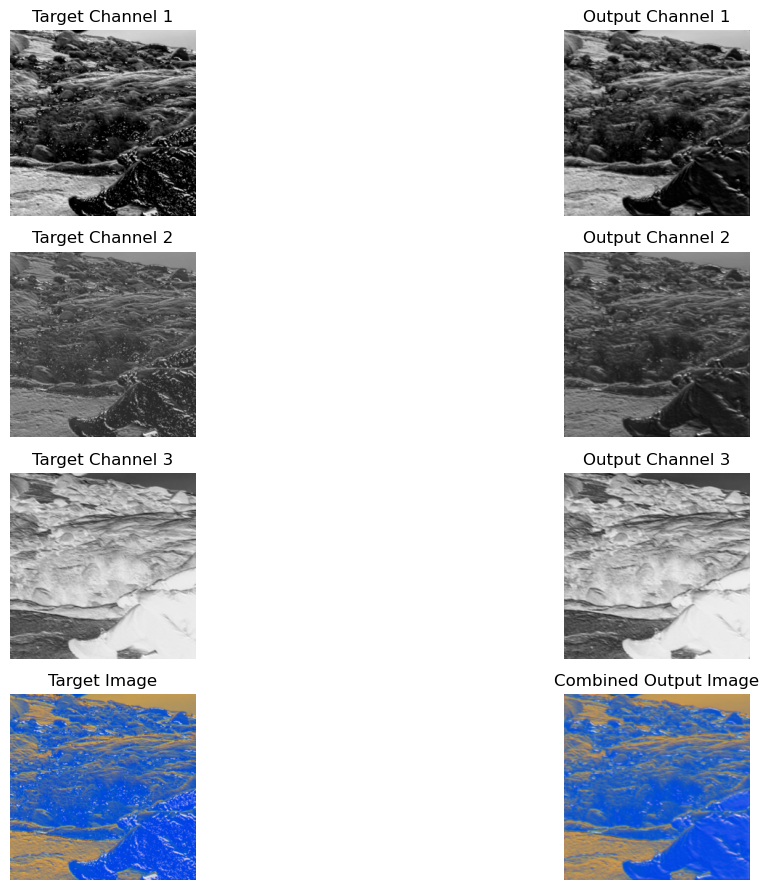

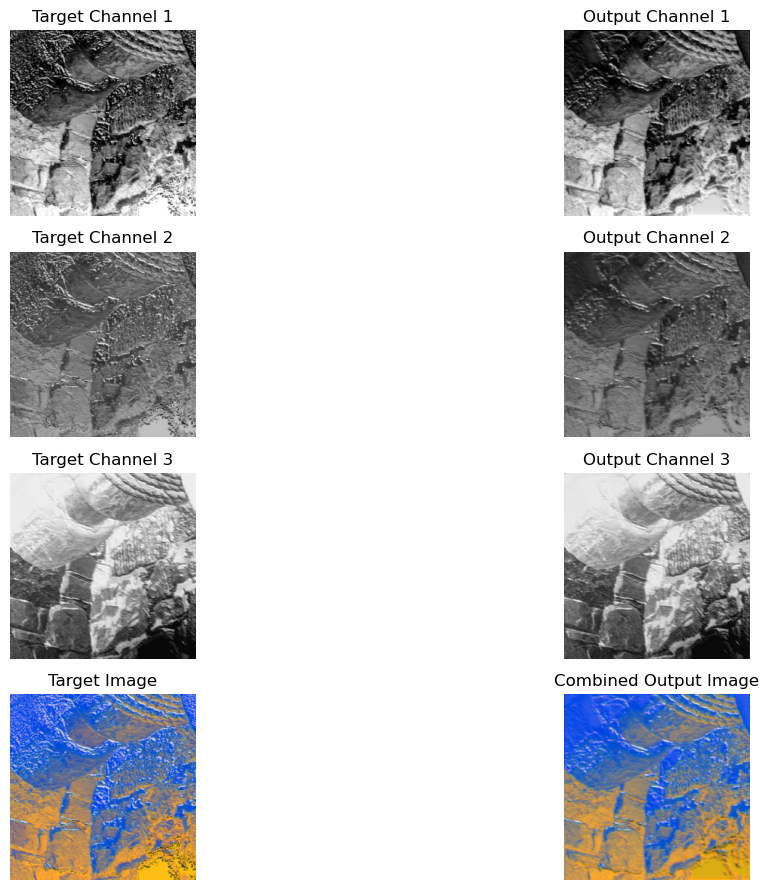

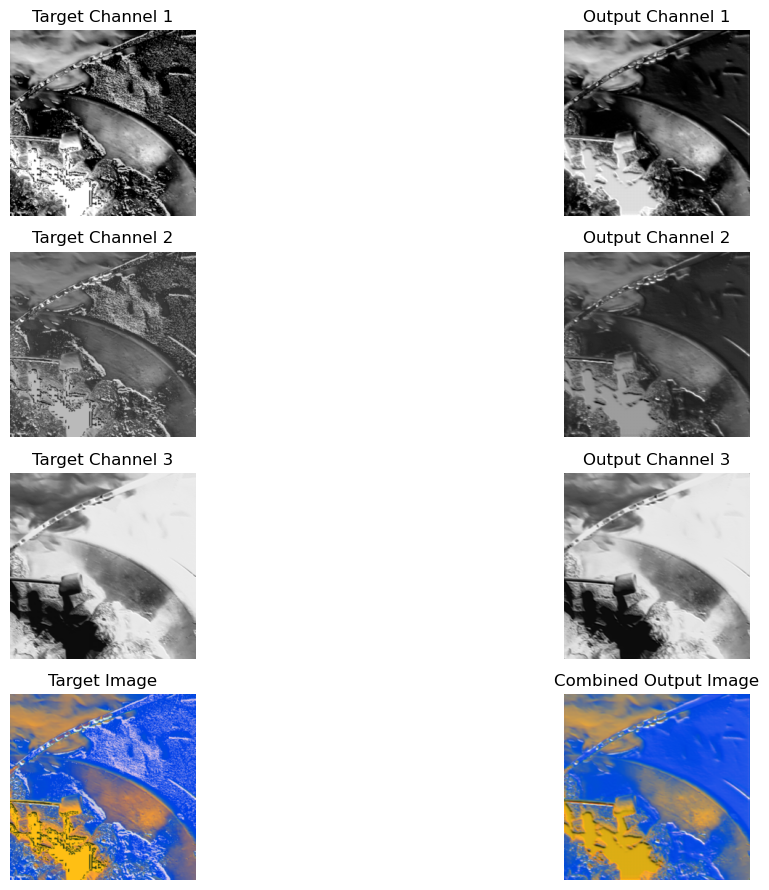

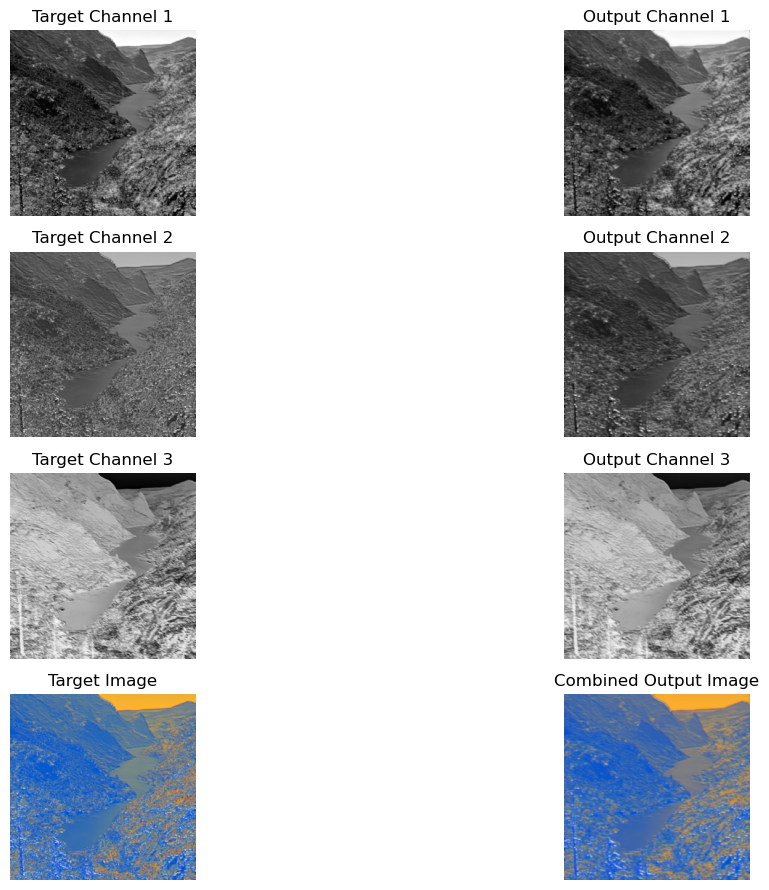

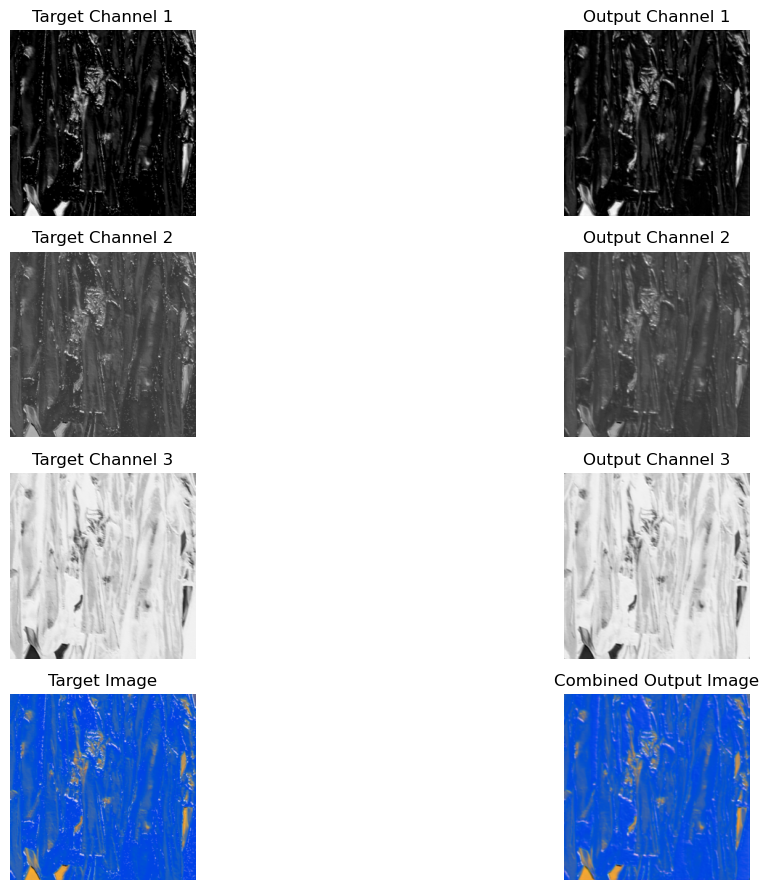

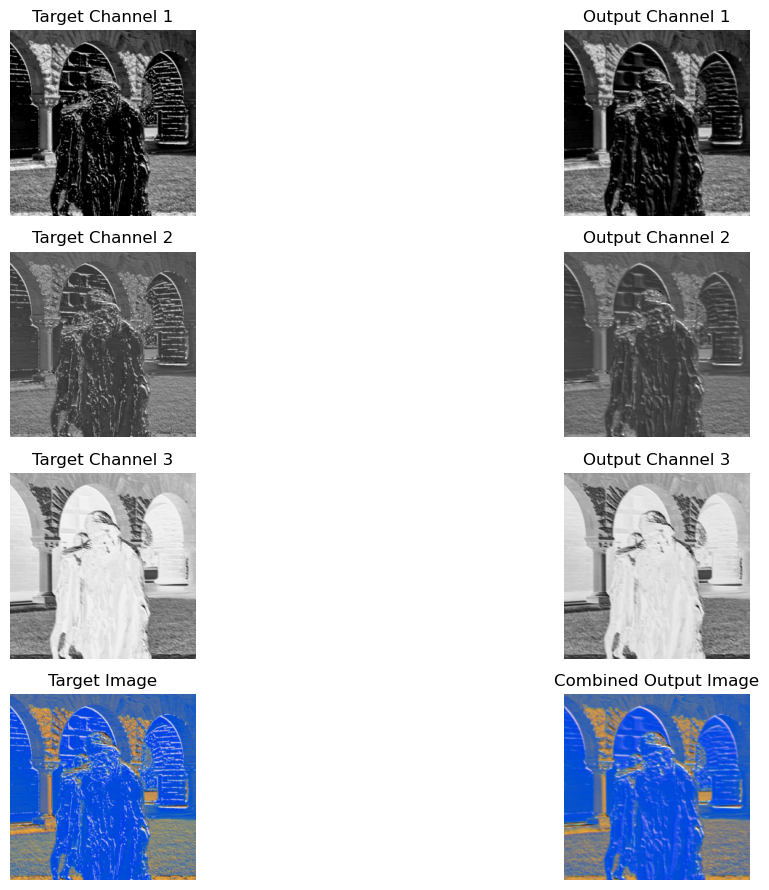

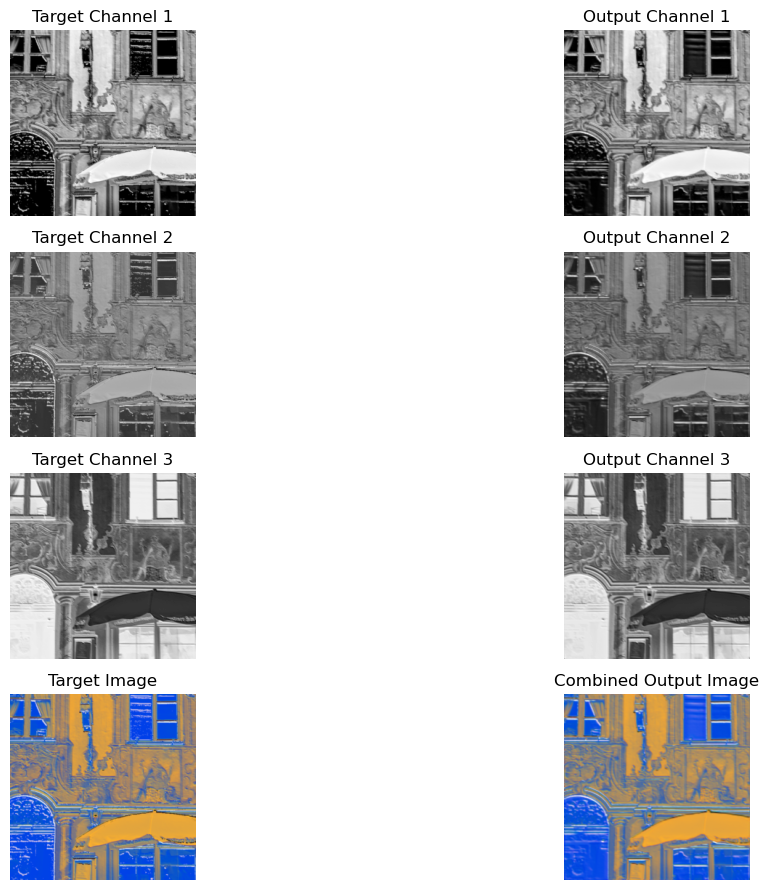

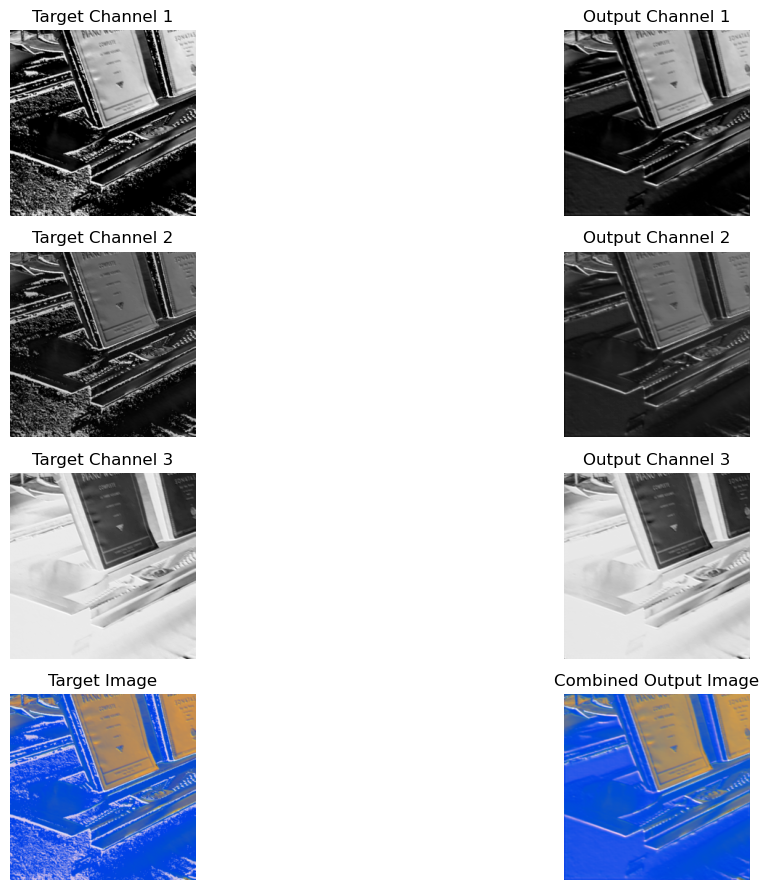

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Function to convert a tensor to a numpy image
def tensor_to_image(tensor):
    # Convert from (C, H, W) to (H, W, C)
    tensor = tensor.cpu().detach()
    image = tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    
    # Normalize to [0, 1] if values are in a different range
    
    image = image.clip(0, 1) 
    
    return image

# Modify the test and plot function to work with multiple models and combine outputs

sample_idx = 2
def test_and_plot(models, val_loader, device, sample_idx=0):
    for model in models:
        model.eval()  # Set all models to evaluation mode

    with torch.no_grad():
        for _, (images, targets) in zip(range(10), val_loader):
            images = images.to(device)  # Input image
            targets = [target.to(device) for target in targets.values()]  # List of target channels

            # Forward pass through each model for each channel
            outputs = [models[channel](images) for channel in range(3)]
            
            # Combine the output channels into a single image
            combined_output = torch.cat(outputs, dim=1)  # Combine along the channel dimension
            combined_output_image = tensor_to_image(combined_output[sample_idx])
            
            combined_target = torch.cat(targets, dim=1)  # Combine along the channel dimension


            # Visualize the results for a specific sample (e.g., the 0th in the batch)
            input_image = tensor_to_image(images[sample_idx])  # Input image
            
            # Convert targets and outputs for each channel to numpy images
            target_images = [tensor_to_image(target[sample_idx]) for target in targets]
            combined_target = tensor_to_image(combined_target[sample_idx])
            output_images = [tensor_to_image(output[sample_idx]) for output in outputs]
            # Combine the output channels into a single image
            

            # Plot the input image, target images, output images, and combined image
            num_channels = 3
            fig, axes = plt.subplots(4, 2, figsize=(15, 9))  # +2 for input and combined

            for channel in range(num_channels):
                    
                # Plot target images for each channel
                axes[channel, 0].imshow(target_images[channel], cmap='gray')
                axes[channel, 0].set_title(f'Target Channel {channel + 1}')
                axes[channel, 0].axis('off')

                # Plot output images for each channel
                axes[channel, 1].imshow(output_images[channel], cmap='gray')
                axes[channel, 1].set_title(f'Output Channel {channel + 1}')
                axes[channel, 1].axis('off')

            axes[channel+1, 0].imshow(combined_target)
            axes[channel+1, 0].set_title('Target Image')
            axes[channel+1, 0].axis('off')
            
            # Plot the combined output image
            axes[channel+1, 1].imshow(combined_output_image)
            axes[channel+1, 1].set_title('Combined Output Image')
            axes[channel+1, 1].axis('off')
            

            plt.tight_layout()
            plt.show()

# Main script to test and plot the images
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for model in models:
    model.to(device)

# Use the function to plot images from the validation set
test_and_plot(models, val_loader, device, sample_idx=sample_idx)
